In [1]:
# -*- coding: utf-8 -*-
import os
import sys
import xlrd
from copy import deepcopy
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# 图片设置
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# 解决中文显示问题
plt.rcParams['font.sans-serif']=['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
pd.set_option('display.max_columns', 1000)

##    ** 数据最全的站点 **

In [2]:
data_dir = './hourly_data'
# 中国环境监测总站, 数据较全
jczz = os.path.join(data_dir, '110000012.txt')

data = pd.read_csv(
    jczz, 
    sep=',', 
    names=[
        'time','stationcode','longitude','latitude',
        'PM10','PM25',
        'Cl-','NO3-','SO42-','Ca2+','Na+','K+','NH4+','Mg2+',
        'OC','EC',
        'Hg','Br','As','Si','Se','Te','V','Ca','Ti','Ba','Sc',
        'Pd','Co','Mo','K','Fe','Pb','TI','Cu','Cr','Cs','Ag',
        'Zn','Sb','Sn','Mn','Cd','Ni','Ga'],
    encoding='utf-8')

In [3]:
# -999.0 表示无效记录，但至少有记录表示，有些时间段是完全没有记录的
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 45 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         8760 non-null   object 
 1   stationcode  8760 non-null   int64  
 2   longitude    8760 non-null   float64
 3   latitude     8760 non-null   float64
 4   PM10         8760 non-null   float64
 5   PM25         8760 non-null   float64
 6   Cl-          8760 non-null   float64
 7   NO3-         8760 non-null   float64
 8   SO42-        8760 non-null   float64
 9   Ca2+         8760 non-null   float64
 10  Na+          8760 non-null   float64
 11  K+           8760 non-null   float64
 12  NH4+         8760 non-null   float64
 13  Mg2+         8760 non-null   float64
 14  OC           8760 non-null   float64
 15  EC           8760 non-null   float64
 16  Hg           8760 non-null   float64
 17  Br           8760 non-null   float64
 18  As           8760 non-null   float64
 19  Si    

+ 先进行组分分类，分别关联PM10，PM25以便后期分析
+ 第一步预处理，替换无效值
+ 处理时间
+ 单位转化

In [4]:
obs_metal = data[['time', 'PM10', 'PM25', 'Hg','Br','As','Si','Se','Te','V','Ca','Ti','Ba','Sc',
    'Pd','Co','Mo','K','Fe','Pb','TI','Cu','Cr','Cs','Ag', 'Zn','Sb','Sn','Mn','Cd','Ni','Ga']]
obs_metal.replace(-999.0, np.nan, inplace=True)
obs_metal['time'] = obs_metal['time'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d:%H"))
obs_metal[obs_metal.columns[3:]] = obs_metal[obs_metal.columns[3:]].apply(lambda x: x/1000, axis=1)

In [54]:
obs_metal.sample(3)

,time,PM10,PM25,Hg,Br,As,Si,Se,Te,V,Ca,Ti,Ba,Sc,Pd,Co,Mo,K,Fe,Pb,TI,Cu,Cr,Cs,Ag,Zn,Sb,Sn,Mn,Cd,Ni,Ga
3445,2019-05-24 13:00:00,81.18,71.87,0.00200,0.028880,0.009782,0.481760,NaN,NaN,0.000292,0.274723,0.021087,0.014405,NaN,NaN,0.005005,NaN,0.338301,0.266905,0.020998,NaN,NaN,0.011110,0.012223,NaN,0.026020,NaN,0.00583,0.057869,NaN,NaN,NaN
7902,2019-11-26 06:00:00,54.66,29.96,0.00013,0.026199,NaN,0.404166,0.007921,NaN,0.001240,0.422742,0.018917,0.031439,0.001333,NaN,0.004672,0.154335,0.343132,0.660398,0.067817,0.007733,0.260114,0.021666,0.002420,NaN,0.171506,NaN,NaN,0.090091,NaN,0.01541,0.002573
1257,2019-02-22 09:00:00,106.49,118.56,0.00231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
obs_metal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    8760 non-null   datetime64[ns]
 1   PM10    8704 non-null   float64       
 2   PM25    8705 non-null   float64       
 3   Hg      7748 non-null   float64       
 4   Br      8251 non-null   float64       
 5   As      6260 non-null   float64       
 6   Si      8359 non-null   float64       
 7   Se      5705 non-null   float64       
 8   Te      1019 non-null   float64       
 9   V       3412 non-null   float64       
 10  Ca      8482 non-null   float64       
 11  Ti      7581 non-null   float64       
 12  Ba      7454 non-null   float64       
 13  Sc      5426 non-null   float64       
 14  Pd      1459 non-null   float64       
 15  Co      5135 non-null   float64       
 16  Mo      4400 non-null   float64       
 17  K       8058 non-null   float64       
 18  Fe      

In [9]:
# 完整的数据只有16组观测
obs_metal.dropna().shape

(16, 32)

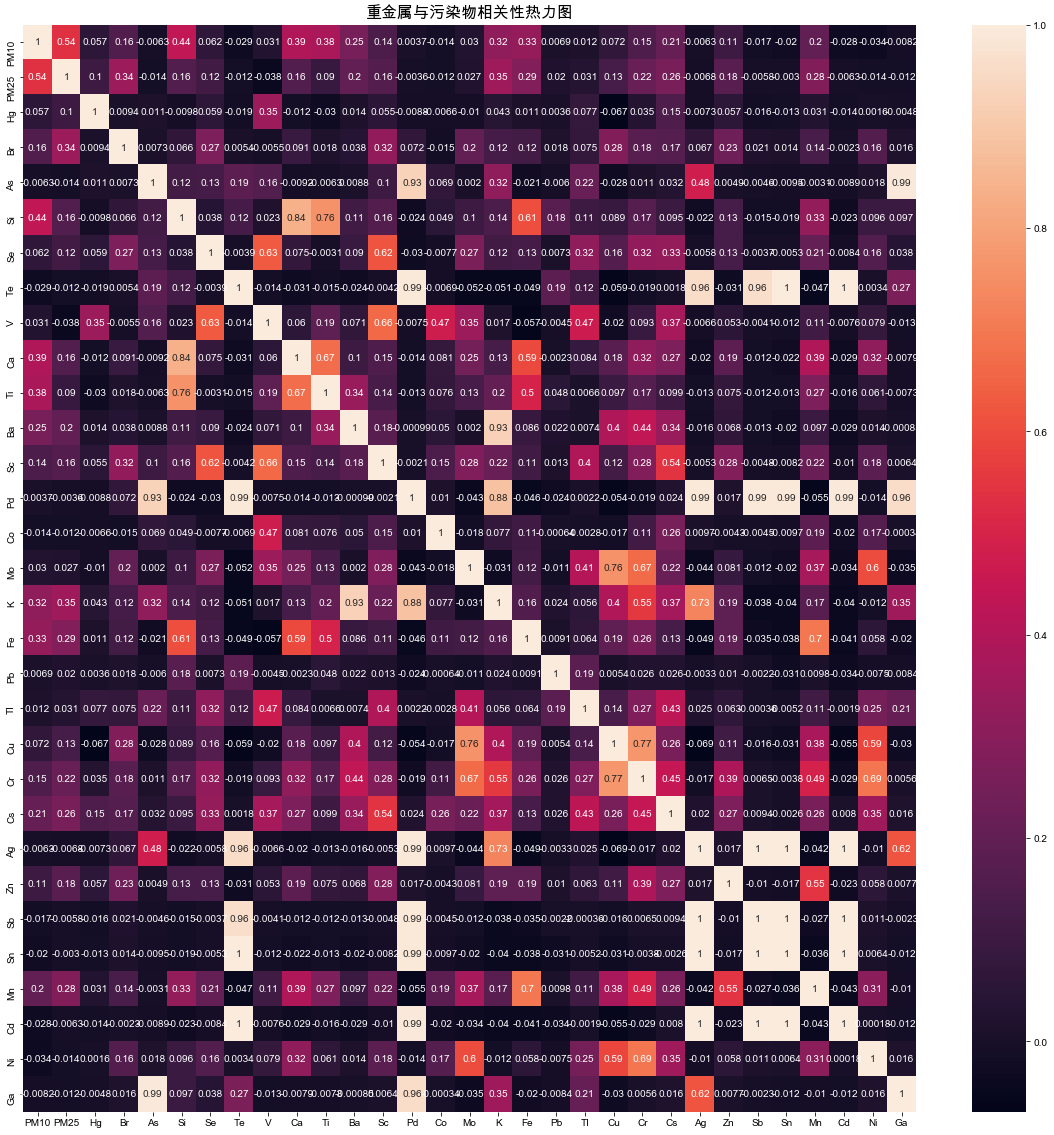

In [66]:
plt.figure(figsize=(20, 20))
sns.heatmap(obs_metal.corr(), annot=True)
plt.title('重金属与污染物相关性热力图', fontsize=16)
plt.savefig('../DataVisual/images/重金属与污染物相关性热力图.png')
plt.show()

+ 看下数据的统计分布

In [25]:
obs_metal[['PM25', 'Ca', 'Si', 'Fe']].describe(percentiles=[.08, .09, .1, .7, .8, .9, .95, .99])

,PM25,Ca,Si,Fe
count,8705.000000,8482.000000,8359.000000,8.440000e+03
mean,45.263637,0.474780,0.768535,5.401968e-01
std,40.918336,0.646741,1.157466,5.737809e-01
min,0.039000,0.000043,0.000392,4.000000e-07
8%,11.240000,0.099010,0.140636,9.241176e-02
9%,11.788720,0.105080,0.152601,9.933123e-02
10%,12.340000,0.110762,0.163405,1.062583e-01
50%,32.940000,0.299762,0.488299,3.979925e-01
70%,51.448000,0.480103,0.731566,6.315204e-01
80%,65.660000,0.631025,0.960449,7.866128e-01


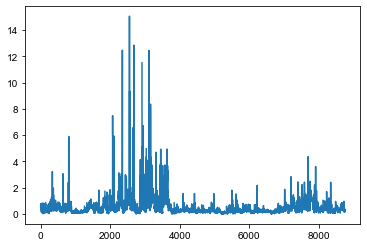

In [26]:
obs_metal['Ca'].plot()

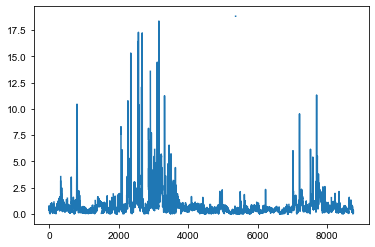

In [27]:
obs_metal['Si'].plot()

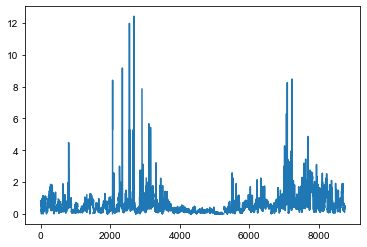

In [28]:
obs_metal['Fe'].plot()

In [18]:
obs_metal[[
    'PM25','Hg','Br','As','Se','Te','V','Ti','Ba','Sc','Pd','Co','Mo','K','Pb',
    'TI','Cu','Cr','Cs','Ag', 'Zn','Sb','Sn','Mn','Cd','Ni','Ga']].describe(percentiles=[.05, .7, .8, .9, .95, .99])

,PM25,Hg,Br,As,Se,Te,V,Ti,Ba,Sc,Pd,Co,Mo,K,Pb,TI,Cu,Cr,Cs,Ag,Zn,Sb,Sn,Mn,Cd,Ni,Ga
count,8705.000000,7748.000000,8251.000000,6260.000000,5705.000000,1019.000000,3412.000000,7581.000000,7454.000000,5.426000e+03,1459.000000,5135.000000,4400.000000,8058.000000,7.284000e+03,4337.000000,5153.000000,6559.000000,5429.000000,899.000000,6.299000e+03,1322.000000,966.000000,8078.000000,8.240000e+02,4131.000000,5453.000000
mean,45.263637,0.001285,0.024287,0.022493,0.008322,0.926707,0.006361,0.044468,0.054525,4.178224e-03,0.107136,0.021901,0.073918,0.497796,4.406314e-02,0.004933,0.116596,0.010367,0.006626,0.202938,1.218175e-01,0.498493,0.495430,0.065093,1.818783e-01,0.012197,0.024479
std,40.918336,0.002534,0.022886,0.604443,0.012486,10.414635,0.031742,0.074506,0.202249,6.564319e-03,1.440946,1.134479,0.070389,1.210809,7.599653e-01,0.008169,0.110047,0.010884,0.008536,2.062605,3.046551e-01,5.786266,6.538493,0.061643,2.258709e+00,0.014184,0.679642
min,0.039000,0.000010,0.000007,0.000001,0.000001,0.000287,0.000001,0.000053,0.000030,7.000000e-07,0.000026,0.000001,0.000004,0.000013,3.000000e-07,0.000001,0.000003,0.000002,0.000003,0.000081,3.000000e-07,0.000228,0.000183,0.000008,1.000000e-07,0.000009,0.000003
50%,32.940000,0.000720,0.018909,0.005765,0.006874,0.116591,0.002507,0.025472,0.026802,2.904000e-03,0.014289,0.005001,0.059649,0.311528,2.406150e-02,0.003634,0.093181,0.008154,0.004594,0.037613,8.580900e-02,0.104079,0.068750,0.049734,2.773300e-02,0.009390,0.007453
70%,51.448000,0.001100,0.027007,0.008969,0.009999,0.217795,0.004352,0.036984,0.040798,4.925500e-03,0.027207,0.007378,0.092326,0.492803,3.904290e-02,0.005457,0.143774,0.012357,0.007515,0.069040,1.392452e-01,0.180949,0.137217,0.073582,5.366380e-02,0.013942,0.010941
80%,65.660000,0.001501,0.033875,0.011441,0.012006,0.361487,0.005980,0.048916,0.053475,6.508000e-03,0.051974,0.008926,0.114816,0.640739,5.127400e-02,0.006801,0.182180,0.015212,0.009773,0.103242,1.828674e-01,0.297371,0.233156,0.094570,8.237280e-02,0.017132,0.013100
90%,91.640000,0.002509,0.049052,0.014946,0.015348,0.811045,0.010981,0.083445,0.082557,8.999000e-03,0.116930,0.011236,0.149786,0.947072,7.710630e-02,0.008929,0.243012,0.019841,0.013822,0.261450,2.548322e-01,0.606195,0.464676,0.128080,1.940288e-01,0.021912,0.016280
95%,128.688000,0.004083,0.064900,0.018050,0.018709,1.498306,0.019111,0.176618,0.153770,1.130075e-02,0.263904,0.013402,0.176741,1.249081,1.051000e-01,0.010982,0.292797,0.024187,0.018495,0.407415,3.321736e-01,1.142203,0.785576,0.167180,2.685156e-01,0.027092,0.018893
99%,196.977600,0.009834,0.104456,0.031395,0.031045,5.716154,0.037059,0.332397,0.403430,1.758125e-02,0.700335,0.019050,0.298560,2.642618,1.858702e-01,0.031986,0.466431,0.055807,0.036138,0.819943,5.424289e-01,3.489347,2.553145,0.278287,1.013259e+00,0.086378,0.028087


In [20]:
# 计算百分位数

obs_metal['Ca'].quantile(q=0.95), obs_metal['Te'].quantile(q=.05)

(1.3207600999999995, 0.006095)

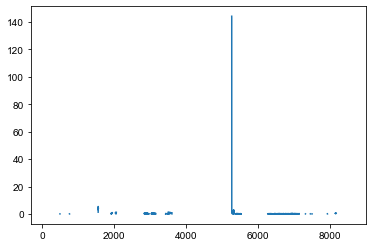

In [31]:
# 其他元素 99%分位数 大于 1up/m3 的情况分析
obs_metal['Sn'].plot()

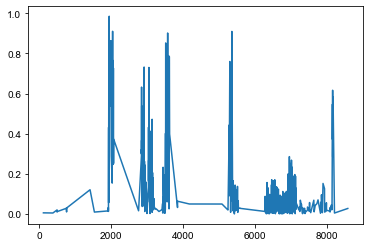

In [38]:
# 其他元素 99%分位数 大于 1up/m3 的情况分析
obs_metal[(obs_metal['Sn']>0)&(obs_metal['Sn']<1)]['Sn'].plot()

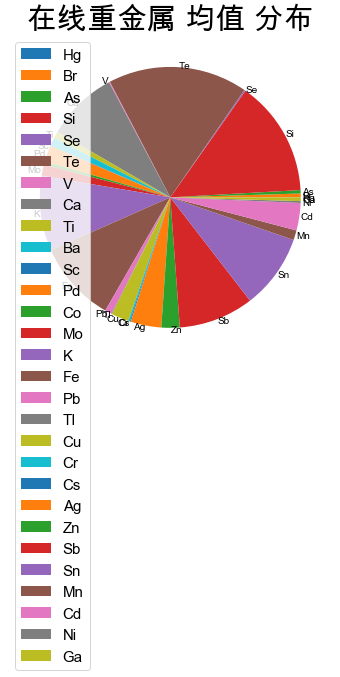

In [59]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.pie(
    x=obs_metal.describe()[1:2][obs_metal.columns[3:]], 
    labels=obs_metal.describe().columns[2:], 
    labeldistance=1.01)
ax.set_title('在线重金属 均值 分布', fontsize=30)
ax.legend(loc='upper left', fontsize=15)
# plt.savefig('../DataVisual/images/在线重金属 均值 分布.png')
plt.show()

In [21]:
obs_metal.describe()[1:2][obs_metal.columns[3:]]

,Hg,Br,As,Si,Se,Te,V,Ca,Ti,Ba,Sc,Pd,Co,Mo,K,Fe,Pb,TI,Cu,Cr,Cs,Ag,Zn,Sb,Sn,Mn,Cd,Ni,Ga
mean,0.001285,0.024287,0.022493,0.768535,0.008322,0.926707,0.006361,0.47478,0.044468,0.054525,0.004178,0.107136,0.021901,0.073918,0.497796,0.540197,0.044063,0.004933,0.116596,0.010367,0.006626,0.202938,0.121817,0.498493,0.49543,0.065093,0.181878,0.012197,0.024479


+ 当所有元素浓度加合大于 PM2.5浓度时，则该小时所有项目监测结果判定为异常数据。
---
+ 当单一项目监测结果突然出现单点异常高值或低值（离群，脱离总体趋势），则该数据异常。
---
+ 正常情况下，Ca 和 Si 监测值范围为 0.1-10μg/m3，Al 不大于 5μg/m3，Fe 不大于 2μg/m3，
---
+ 其它元素一般不大于 1μg/m3。重污染天气或沙尘天气可能会大于各项目限定值，优良天气可能会小于各项目限定值，具体需要结合颗粒物变化趋势判断是否异常。

In [52]:
for _, x in enumerate(['Ca', 'Si', 'Fe']):
    print("{} not na : {}".format(x, obs_metal[x].notna().sum()))

Ca not na : 8482
Si not na : 8359
Fe not na : 8440


In [53]:
obs_metal[obs_metal[['Fe']]>=0].shape, obs_metal[obs_metal[['Fe']]<2].shape

((8760, 33), (8760, 33))

In [44]:
obs_metal[obs_metal['Ca']<=10].shape, obs_metal[obs_metal['Ca']>10].shape

((8477, 33), (5, 33))

In [68]:
obs_metal['total'] = obs_metal[obs_metal.columns[3:]].apply(lambda x: x.sum(), axis=1)
obs_metal.shape

(8760, 33)

In [55]:
obs_metal.dropna().shape

(16, 32)

In [36]:
# total < PM25
obs_metal[obs_metal['PM25']<obs_metal['total']].shape

(117, 33)

In [37]:
obs_metal[obs_metal['PM25']<obs_metal['total']].sample(3)

,time,PM10,PM25,Hg,Br,As,Si,Se,Te,V,Ca,Ti,Ba,Sc,Pd,Co,Mo,K,Fe,Pb,TI,Cu,Cr,Cs,Ag,Zn,Sb,Sn,Mn,Cd,Ni,Ga,total
7526,2019-11-10 14:00:00,41.21,15.73,0.00008,0.016059,NaN,5.812273,0.010262,NaN,NaN,2.229522,0.214385,0.049888,NaN,NaN,0.008456,0.002100,0.702927,2.236724,0.010080,0.001638,0.061814,0.006905,NaN,NaN,0.017009,NaN,NaN,0.101803,NaN,NaN,0.016793,22.997436
6160,2019-09-14 16:00:00,22.78,2.60,0.00028,0.002166,0.001529,0.570054,NaN,NaN,NaN,0.233897,0.031308,0.034059,0.000274,NaN,NaN,NaN,0.330114,0.403450,0.014349,NaN,NaN,NaN,0.002860,NaN,NaN,NaN,NaN,0.007904,NaN,NaN,0.004806,3.274100
3001,2019-05-06 01:00:00,115.85,15.59,0.00032,0.023758,0.002895,4.175128,NaN,NaN,NaN,3.026473,0.203753,0.051071,NaN,0.019631,0.010201,0.008712,0.569204,1.328588,0.012975,0.004088,0.037530,0.011550,0.005339,NaN,0.050565,NaN,NaN,0.067341,NaN,NaN,NaN,19.218244


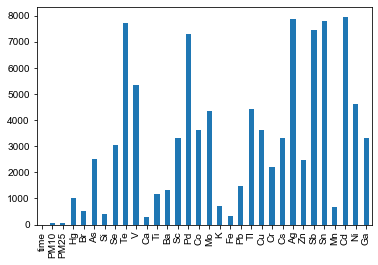

In [31]:
obs_metal[obs_metal.columns].isna().sum().plot(kind='bar')

In [72]:
obs_metal[['PM25','total']].corr()

,PM25,total
PM25,1.0000,0.0929
total,0.0929,1.0000


In [39]:
# miss obs
obs_metal1 = obs_metal[obs_metal.isnull().values==True].drop_duplicates()
obs_metal1.shape

(8744, 32)

In [62]:
def plot_line(df):
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(df['time'], df['total'], color='g', label='total(μg/m3)')
    ax.plot(df['time'], df['PM25'], color='b', label='PM25(μg/m3)')
    
    ax.set_xlabel('时间', fontsize=15)
    ax.set_ylabel('浓度', fontsize=15)
    ax.set_title('PM25 vs. Total 逐小时变化', fontsize=18)

    ax.xaxis.set_tick_params(rotation=50, labelsize=12)
    xstart, xend = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(xstart, xend, 10))
    ax.yaxis.set_tick_params(labelsize=14)
    ax.legend(fontsize=15)
    plt.show()

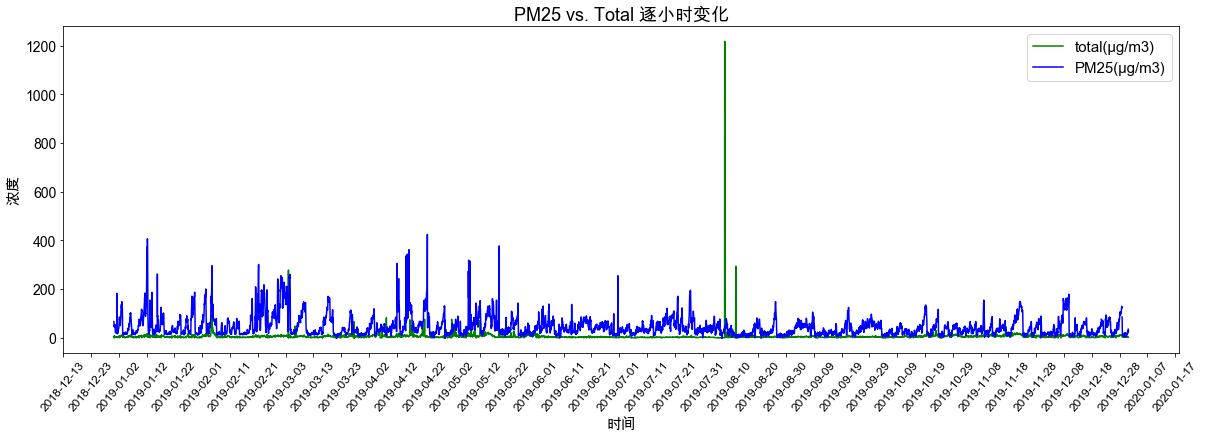

In [63]:
plot_line(obs_metal)

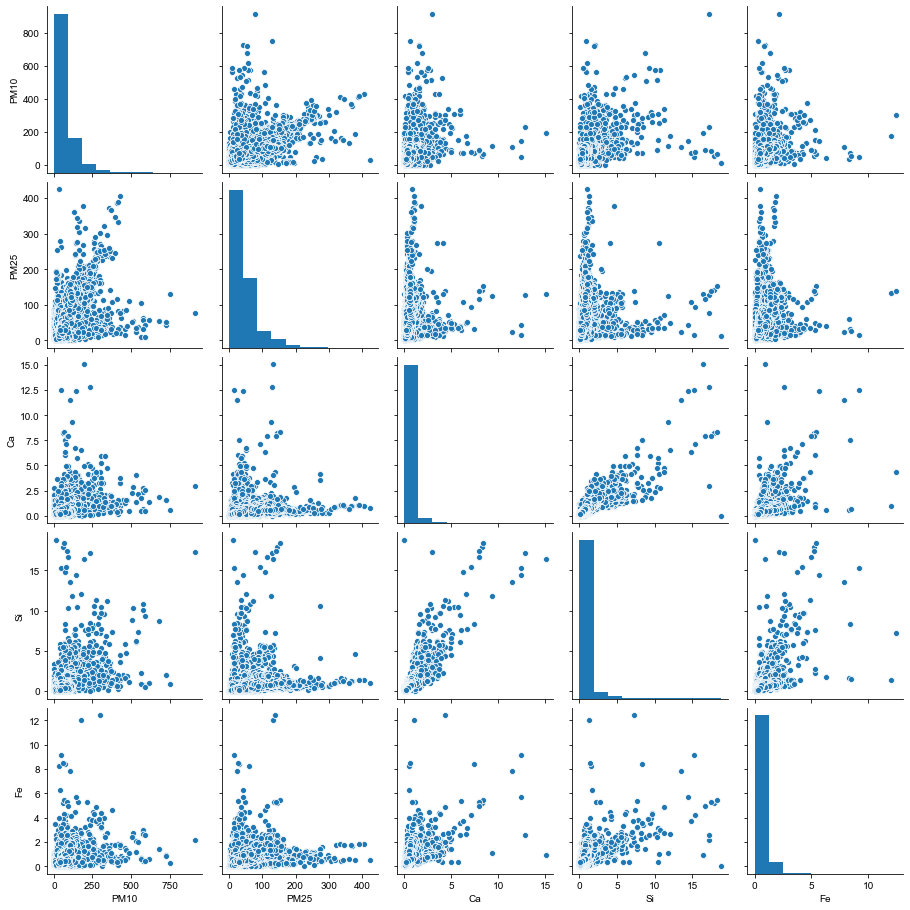

In [43]:
sns.pairplot(obs_metal[['PM10', 'PM25', 'Ca', 'Si', 'Fe']])

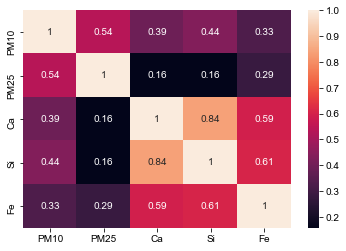

In [42]:
sns.heatmap(obs_metal[['PM10', 'PM25', 'Ca', 'Si', 'Fe']].corr(), annot=True)

In [44]:
# patay 方式建立线性模型
import past
from patsy import dmatrices

y, X = dmatrices('y ~ x', obs_metal[['Ca', 'Si']].rename(
    columns={'Ca': 'x', 'Si': 'y'}))
# Patsy对象可以直接传递到算法（比如numpy.linalg.lstsq）中，它执行普通最小二乘回归
coef, resid, _, _ = np.linalg.lstsq(X, y, rcond=-1)
# 模型的元数据保留在design_info属性中，因此你可以重新附加列名到拟合系数
coef = pd.Series(coef.squeeze(), index=X.design_info.column_names)
coef

Intercept    0.052687
x            1.495535
dtype: float64

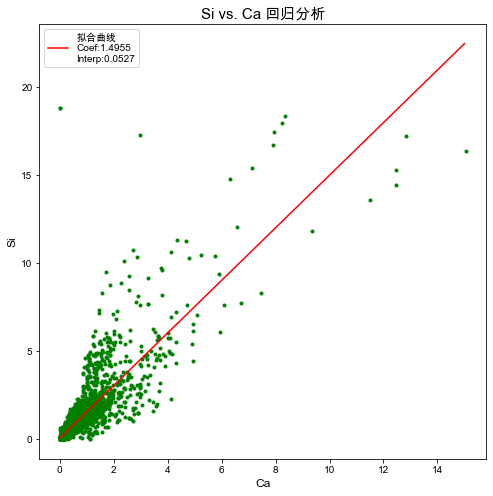

In [53]:
# 可视化结果
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(obs_metal['Ca'], obs_metal['Si'], color='g', marker='.')
ax.plot(
    np.arange(0, obs_metal['Ca'].max()), 
    coef.x*np.arange(0, obs_metal['Ca'].max())+coef.Intercept,
    color='r', label='拟合曲线\nCoef:{}\nInterp:{}'.format(round(coef.x,4), round(coef.Intercept,4)))
ax.set_title('Si vs. Ca 回归分析', fontsize=15)
ax.set_xlabel('Ca', fontsize=12)
ax.set_ylabel('Si', fontsize=12)
plt.legend()
plt.show()